## Binary classification with CNN

The paths utilized are defiend in the `path_module.py`

Before this, the data must be processed and tokenized. 
1. `data_processing` notebook loads raw data and prepares training,validation and test dataset
2. `data_tokenizer`notebook tokenizes the data using LiPCoT model

### 1. Import libraries

In [84]:
from modules.bert_module import *
from modules.path_module import *
from modules.utils_module import *
import os
import joblib
import torch
import numpy as np

### 2. Load tokenized data

In [85]:
train_data=joblib.load(os.path.join(tokenized_data_savepath,"train_data.joblib"))
test_data=joblib.load(os.path.join(tokenized_data_savepath,"test_data.joblib"))
val_data=joblib.load(os.path.join(tokenized_data_savepath,"val_data.joblib"))

### 3. Prepare data
- We extract only the signal data and labels from dataset for CNN
- We train using the training set and save the model that gives the best performance on the validation set

In [86]:
train_sigdata,train_label=prepare_cnn_data(val_data)
val_sigdata,val_label=prepare_cnn_data(train_data)
test_sigdata,test_label=prepare_cnn_data(test_data)

### 4. DeepConvNet model

- Paper: https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23730
- Pytorch conversion from keras implementation https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
- Another useful link: https://github.com/TNTLFreiburg/braindecode/tree/master/braindecode
- Pytorch implementation of the Deep Convolutional Network as described in Schirrmeister et. al. (2017), Human Brain Mapping.
- In PyTorch, kernel constraints like max_norm are not directly implemented as part of the layer definitions.

- Assumes the input is a 5-second EEG signal sampled at 500Hz. 

- Note that we use the max_norm constraint on all convolutional layers, as well as the classification layer.
- In PyTorch, kernel constraints like max_norm are not directly implemented as part of the layer definitions. Instead, they can be implemented using hooks or by manually enforcing the constraint during the forward pass or after updating the weights. 
- Model was developed with hyperparameters from original paper 

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def max_norm(layer, max_value, axis=0):
    with torch.no_grad():
        norm = layer.weight.norm(2, dim=axis, keepdim=True)
        desired = torch.clamp(norm, 0, max_value)
        scale = desired / (1e-8 + norm)
        layer.weight.data *= scale

class DeepConvNet(nn.Module):
    def __init__(self, nb_classes, Chans=64, Samples=256, dropoutRate=0.5):
        super(DeepConvNet, self).__init__()

        # Block 1
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=25, kernel_size=(1, 10), padding=0)
        self.conv1_2 = nn.Conv2d(in_channels=25, out_channels=25, kernel_size=(Chans, 1), padding=0)
        self.batchnorm1 = nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.9)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        self.dropout1 = nn.Dropout(p=dropoutRate)

        # Block 2
        self.conv2 = nn.Conv2d(in_channels=25, out_channels=50, kernel_size=(1, 10), padding=0)
        self.batchnorm2 = nn.BatchNorm2d(num_features=50, eps=1e-05, momentum=0.9)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        self.dropout2 = nn.Dropout(p=dropoutRate)

        # Block 3
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=100, kernel_size=(1, 10), padding=0)
        self.batchnorm3 = nn.BatchNorm2d(num_features=100, eps=1e-05, momentum=0.9)
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        self.dropout3 = nn.Dropout(p=dropoutRate)

        # Block 4
        self.conv4 = nn.Conv2d(in_channels=100, out_channels=200, kernel_size=(1, 10), padding=0)
        self.batchnorm4 = nn.BatchNorm2d(num_features=200, eps=1e-05, momentum=0.9)
        self.pool4 = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        self.dropout4 = nn.Dropout(p=dropoutRate)

        # Fully connected layer
        self.fc = nn.Linear(in_features=200 * 26, out_features=nb_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension: (batch_size, 1, Chans, Samples)

        # Block 1
        x = self.conv1_1(x) # batch x 25 x chan x  sample -9=2491
        max_norm(self.conv1_1, 2.0, axis=(0, 1, 2))
        x = self.conv1_2(x) # batch x 25 x 1 x  sample -10
        max_norm(self.conv1_2, 2.0, axis=(0, 1, 2))
        x = self.batchnorm1(x)
        x = F.elu(x)
        x = self.pool1(x) # batch x 25 x 1 x  (2491-3)//3+1= 830
        x = self.dropout1(x)

        # Block 2
        x = self.conv2(x) # batch x 50 x 1 x  830-9=821
        max_norm(self.conv2, 2.0, axis=(0, 1, 2))
        x = self.batchnorm2(x)
        x = F.elu(x)
        x = self.pool2(x) # batch x 50 x 1 x  (821-3)//3+1=273
        x = self.dropout2(x)

        # Block 3
        x = self.conv3(x) # batch x 100 x 1 x  273-9=264
        max_norm(self.conv3, 2.0, axis=(0, 1, 2))
        x = self.batchnorm3(x)
        x = F.elu(x)
        x = self.pool3(x) #batch x 100 x 1 x (264-3)//3+1=88
        x = self.dropout3(x)

        # Block 4
        x = self.conv4(x) # batch x 200 x 1 x  88-9=79
        max_norm(self.conv4, 2.0, axis=(0, 1, 2))
        x = self.batchnorm4(x)
        x = F.elu(x)
        x = self.pool4(x) # batch x 200 x 1 x  (79-3)//3+1=26
        x = self.dropout4(x)

        # Flatten and fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        max_norm(self.fc, 0.5, axis=0)

        return x


### 5. Initialize model

In [88]:
import torch.optim as optim
from torch import cuda

# Set the random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# use GPU
device='cpu'#'cuda' if cuda.is_available() else 'cpu'
print("Running on: "+device)
cuda.empty_cache()

# initialize model
n_chan=train_data[0].data.shape[1]
n_datalength=train_data[0].data.shape[0]
model = DeepConvNet(nb_classes=2, Chans=n_chan, Samples=n_datalength, dropoutRate=0.5)
model.to(device)
print('Model created')

Running on: cpu
Model created


### 6. Configure Training

In [89]:
#batch_size = 8#1
batch_size = 64 # from their doc website
num_epochs = 70
#num_epochs = 4 # from their website
lrate=0.0625 * 0.01 # from shallownet
#lrate= 1 * 0.01 # from their doc website. This failed to train the network
weight_decay = 0.5 * 0.001  # from their website
patience=80
# Define loss function and optimizer
criterion = nn.BCELoss()
#optimizer = optim.Adam(model.parameters(), lr=lrate,weight_decay=weight_decay)
#criterion = nn.NLLloss() # from their website
optimizer = optim.AdamW(model.parameters(), lr=lrate,weight_decay=weight_decay) # from their website
cnn_modelfullpath=os.path.join(cnn_modelpath,'deepnet.pt')
random_seed=42

training_arg={
    'modelfullpath': cnn_modelfullpath,
    'criterion': criterion,
    'optimizer': optimizer,
    'epochs': num_epochs,
    'patience': patience,
    'seed': random_seed
}


### 7. Prepare data

In [90]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.stack(train_sigdata), torch.stack(train_label))
val_dataset = TensorDataset(torch.stack(val_sigdata), torch.stack(val_label))
test_dataset = TensorDataset(torch.stack(test_sigdata), torch.stack(test_label))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 8. Train model

In [91]:
results= model_trainer(model,train_loader,val_loader,training_arg)

Epoch 1/70: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


model state saved with validation accuracy: 53.7267


Epoch 21/70: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


model state saved with validation accuracy: 54.9689


Epoch 22/70: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


model state saved with validation accuracy: 55.5901


Epoch 26/70: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


model state saved with validation accuracy: 55.9006


Epoch 34/70: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


model state saved with validation accuracy: 58.3851


Epoch 35/70: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


model state saved with validation accuracy: 59.9379


Epoch 38/70: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


model state saved with validation accuracy: 61.1801


Epoch 40/70: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


model state saved with validation accuracy: 61.8012


Epoch 42/70: 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


model state saved with validation accuracy: 64.9068


Epoch 47/70: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


model state saved with validation accuracy: 68.6335


Epoch 60/70: 100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


model state saved with validation accuracy: 73.2919


Epoch 70/70: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


### 9. Inspect training process

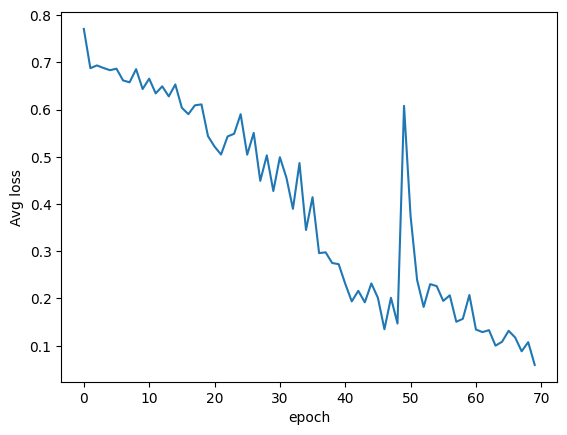

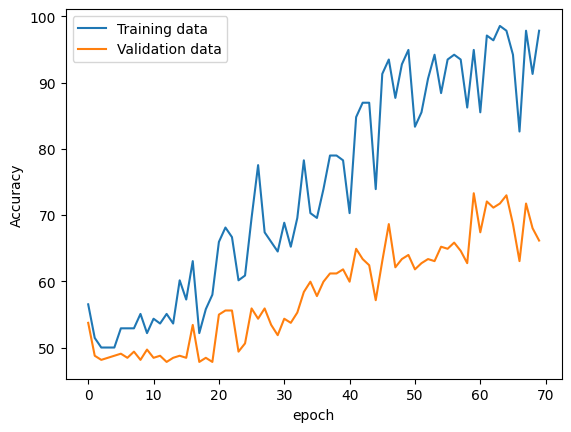

In [92]:
plt.figure()
plt.plot(results['epoch_loss'])
plt.xlabel('epoch')
plt.ylabel('Avg loss')
plt.show()


plt.figure()
plt.plot(results['training_acc'],label='Training data')
plt.plot(results['validation_acc'],label='Validation data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

### 10. Evaluate model

In [93]:
best_model_state=torch.load(cnn_modelfullpath, map_location=device)
model.load_state_dict(best_model_state,strict=True)
model.eval()
print('Fine tune model loaded')

tr_accuracy, tr_est,tr_labels,tr_scores= evaluate_binary_accuracy(model, train_loader)
print(f'Train Binary Accuracy: {tr_accuracy:.4f}')
perf_metrics(tr_labels, tr_est,tr_scores)
print('\n')
v_accuracy,val_est,val_labels, val_scores = evaluate_binary_accuracy(model, val_loader)
print(f'Validation Binary Accuracy: {v_accuracy:.4f}')
perf_metrics(val_labels, val_est,val_scores)
print('\n')
test_accuracy,test_est,test_labels, test_scores = evaluate_binary_accuracy(model, test_loader)
print(f'Test Binary Accuracy: {test_accuracy:.4f}')
perf_metrics(test_labels, test_est,test_scores)

print('Completed')

Fine tune model loaded
Train Binary Accuracy: 94.9275
Confusion Matrix:
[[68  4]
 [ 3 63]]
Accuracy: 94.92753623188406
Precision: 94.02985074626866
Sensitivity (Recall): 95.45454545454545
Specificity: 94.44444444444444
F1 Score: 0.9473684210526316
AUC Score: 0.9945286195286196


Validation Binary Accuracy: 73.2919
Confusion Matrix:
[[111  57]
 [ 29 125]]
Accuracy: 73.29192546583852
Precision: 68.68131868131869
Sensitivity (Recall): 81.16883116883116
Specificity: 66.07142857142857
F1 Score: 0.7440476190476191
AUC Score: 0.7985466914038342


Test Binary Accuracy: 70.6522
Confusion Matrix:
[[34 14]
 [13 31]]
Accuracy: 70.65217391304348
Precision: 68.88888888888889
Sensitivity (Recall): 70.45454545454545
Specificity: 70.83333333333334
F1 Score: 0.6966292134831461
AUC Score: 0.7883522727272726
Completed
